## Name: Akshat Bhat

### Importing and Downloading Utilities & Libraries

In [ ]:
# Importing standard data science related libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [ ]:
# Installing helper utilities
!git clone https://github.com/liady/ssp19ai_utils.git
!git -C ssp19ai_utils pull
import ssp19ai_utils.utils as utils
import importlib
importlib.reload(utils)

Cloning into 'ssp19ai_utils'...
remote: Enumerating objects: 78, done.
remote: Total 78 (delta 0), reused 0 (delta 0), pack-reused 78
Unpacking objects: 100% (78/78), done.
Already up to date.


<module 'ssp19ai_utils.utils' from '/content/ssp19ai_utils/utils.py'>

In [ ]:
# Mounting Google Drive - for storing and loading models
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Fashion MNIST Dataset

In [ ]:
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.fashion_mnist.load_data() # Splitting into training and testing set images and labels

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

**Fashion MNIST Dataset**: This is a dataset of 60,000 28 x 28 grayscale images of 10 fashion categories, along with a test set of 10,000 images with pixel values ranging from 0 to 255. Each label is an array of integers, ranging from 0 to 9.

The classes are:

Label -> Description

0	-> T-shirt/top

1 -> Trouser

2	-> Pullover

3	-> Dress

4	-> Coat

5	-> Sandal

6	-> Shirt

7	-> Sneaker

8	-> Bag

9	-> Ankle boot

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Data Exploration and Preprocessing

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
len(y_train)

60000

In [ ]:
X_test.shape

(10000, 28, 28)

In [ ]:
len(y_test)

10000

There are 60,000 training images and 10,000 images. Each image is 28 x 28 pixels.

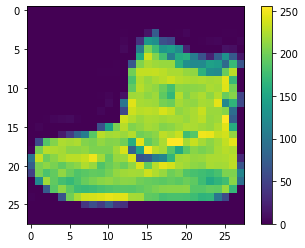

In [ ]:
plt.imshow(X_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

For each image the pixel values are in between 0 and 255, so before inputting the images into the neural network we need to divide the values by 255.

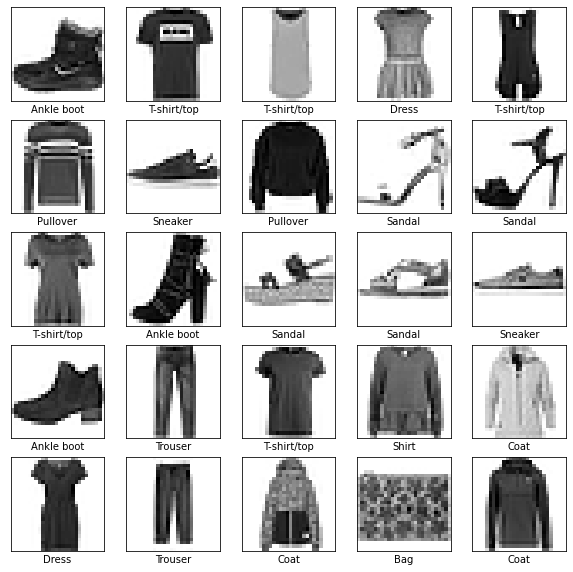

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[int(y_train[i])])
plt.show()

The different types of fashion items have been plotted above after converting into grayscale as the original images are low resolution (blue-yellow colour) type images.

In [ ]:
# Converting images into the (Height, Width, Channel) format where we have just one channel
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

In [ ]:
# Perform One-Hot Encoding target values
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
# Define parameters and constants
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 28

In [ ]:
# Function for Preprocessing an image which includes resizing, converting the datatype to float and scaling the pixel values by dividing by 255.
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image, label

In [ ]:
# Convert the datasets into Tensorflow Datasets, followed by shuffling and mapping the preprocessing function
train_ds_one = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)

train_ds_simple = tf.data.Dataset.from_tensor_slices((X_train, y_train))

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds_simple = (
    train_ds_simple.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Combine two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

test_ds = (
    test_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

### Cutmix Image Augmentation

In CutMix augmentation we cut and paste random patches between the training images. The ground truth labels are mixed in proportion to the area of patches in the images. CutMix increases localization ability by making the model to focus on less discriminative parts of the object being classified and hence is also well suited for tasks like object detection.

In [ ]:
# Define a sample beta distribution function
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

In [ ]:
# Define a function creates and gets a box of some part of an image
@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w

In [ ]:
# Define the function that performs the cutmix operation on two images
@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

In [ ]:
# Create the new dataset using the cutmix function
train_ds_cmu = (
    train_ds.shuffle(1024)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
) # Dataset after cutmix augmentation

In [ ]:
train_ds_cmu.cardinality().numpy()

1875

1875 images were created. 

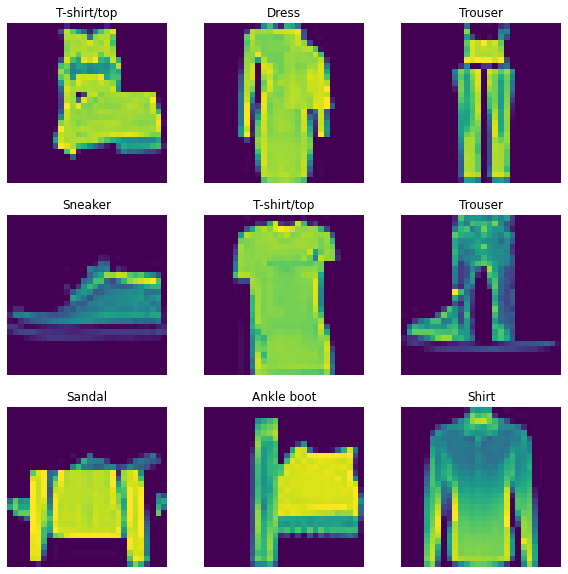

In [ ]:
import cv2
# Preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i].numpy().transpose(2,0,1)[0])
    plt.axis("off")

#### AlexNet Model

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from keras.regularizers import l2

def alexnet_model(img_shape=(28, 28, 1), n_classes=10, l2_reg=0.,
	weights=None):

	# Initialize model
	alexnet = Sequential()

	# Layer 1
	alexnet.add(Conv2D(96, (11, 11), input_shape=img_shape,
		padding='same', kernel_regularizer=l2(l2_reg)))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 2
	alexnet.add(Conv2D(256, (5, 5), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(512, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 4
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))

	# Layer 5
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 6
	alexnet.add(Flatten())
	alexnet.add(Dense(3072))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 7
	alexnet.add(Dense(4096))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 8
	alexnet.add(Dense(n_classes))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('softmax'))

	if weights is not None:
		alexnet.load_weights(weights)

	return alexnet

In [ ]:
model = alexnet_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 96)        11712     
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 96)       384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 256)      1

In [ ]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds_cmu, validation_data=test_ds, epochs=15)

test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/15
1875/1875 [==============================] - 233s 120ms/step - loss: 1.1737 - accuracy: 0.6894 - val_loss: 0.6115 - val_accuracy: 0.8269
Epoch 2/15
1875/1875 [==============================] - 224s 120ms/step - loss: 0.9889 - accuracy: 0.7451 - val_loss: 0.4781 - val_accuracy: 0.8329
Epoch 3/15
1875/1875 [==============================] - 218s 116ms/step - loss: 0.9167 - accuracy: 0.7615 - val_loss: 0.3663 - val_accuracy: 0.8861
Epoch 4/15
1875/1875 [==============================] - 219s 117ms/step - loss: 0.8697 - accuracy: 0.7757 - val_loss: 0.3627 - val_accuracy: 0.8823
Epoch 5/15
1875/1875 [==============================] - 219s 117ms/step - loss: 0.8411 - accuracy: 0.7843 - val_loss: 0.2914 - val_accuracy: 0.9086
Epoch 6/15
1875/1875 [==============================] - 220s 117ms/step - loss: 0.8130 - accuracy: 0.7927 - val_loss: 0.2948 - val_accuracy: 0.9066
Epoch 7/15
1875/1875 [==============================] - 218s 116ms/step - loss: 0.7913 - accuracy: 0.8015 - val_

#### Saving Model

In [ ]:
model.save_weights("/content/drive/MyDrive/AkshatBhat-CodingTask/alexnet_model_weights_cutmix.h5")

In [ ]:
model.save("/content/drive/MyDrive/AkshatBhat-CodingTask/alexnet_model_cutmix.h5")

#### Plotting the Training and Testing Loss and Accuracy Curves

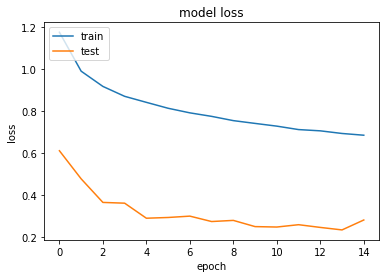

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

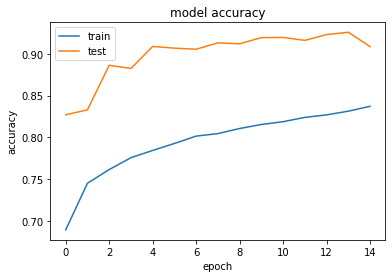

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Loading Model

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('/content/drive/MyDrive/AkshatBhat-CodingTask/alexnet_model_cutmix.h5')

# Show the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 96)        11712     
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 96)       384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 256)      1

#### Examining the Predictions of the Model

In [ ]:
predictions = model.predict(test_ds)

In [ ]:
predictions[0]

array([9.9880846e-05, 9.5883000e-04, 9.4495469e-04, 1.2792590e-03,
       8.0010784e-04, 9.8195858e-02, 2.6211128e-04, 1.1758094e-02,
       2.8647990e-03, 8.8283610e-01], dtype=float32)

In [ ]:
test_labels[0]

9

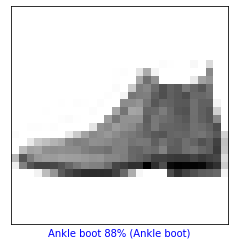

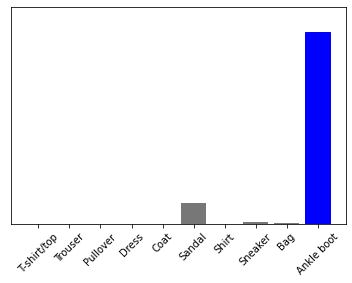

In [ ]:
# Show the 0th image:
index = 0
utils.plot_image_and_prob(predictions, test_labels, test_images, i=index, big=True, class_names=class_names)

Confusion matrix


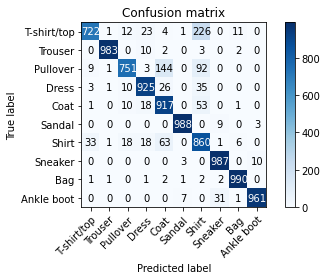

In [ ]:
# As always - let's convert the probabilities array into classes
predicted_classes = utils.label_with_highest_prob(predictions)

# Plot the matrix
utils.plot_confusion_matrix(y_pred=predicted_classes, y_true=test_labels, classes=np.array(class_names))

In [ ]:
from sklearn.metrics import classification_report,roc_curve,confusion_matrix
print('Classification Report\n',classification_report(test_labels, predicted_classes))

Classification Report
               precision    recall  f1-score   support

           0       0.94      0.72      0.82      1000
           1       0.99      0.98      0.99      1000
           2       0.94      0.75      0.83      1000
           3       0.93      0.93      0.93      1000
           4       0.79      0.92      0.85      1000
           5       0.99      0.99      0.99      1000
           6       0.68      0.86      0.76      1000
           7       0.96      0.99      0.97      1000
           8       0.98      0.99      0.98      1000
           9       0.99      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



### Cutout Image Augmentation


Cutout augmentation is a kind of regional dropout strategy in which a random patch from an image is zeroed out (replaced with black pixels). Cutout samples suffer from the decrease in information and regularization capability.

In [ ]:
# Installing Tensorflow Addons Library
!pip install tensorflow-addons==0.9.1
import tensorflow_addons as tfa

     |████████████████████████████████| 1.0 MB 5.3 MB/s 


/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.1.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [ ]:
# Define Random Cutout operation function
@tf.function
def random_cut_out(images, labels):
    return tfa.image.random_cutout(images, (10, 10), constant_values = 1), labels

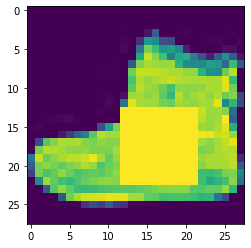

In [ ]:
# Displaying how one image looks after performing the cutout operation
temp = train_ds_simple.map(random_cut_out)
images, _ = next(iter(temp.take(1)))
image = images[0]
plt.imshow(image.numpy().transpose(2,0,1)[0])

In [ ]:
# Create the new dataset using the random cutout function
train_ds_cutout = (
    train_ds_simple.shuffle(1024)
    .map(random_cut_out, num_parallel_calls=AUTO)
)

In [ ]:
train_ds_cutout.cardinality().numpy()

1875

1875 images were created. 

#### Instantiating AlexNet Model and Saving Model

In [ ]:
model2 = alexnet_model()

In [ ]:
model2.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_ds_cutout, validation_data=test_ds, epochs=15)

test_loss2, test_accuracy2 = model2.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy2 * 100))

Epoch 1/15
1875/1875 [==============================] - 121s 57ms/step - loss: 0.6907 - accuracy: 0.7890 - val_loss: 0.3922 - val_accuracy: 0.8678
Epoch 2/15
1875/1875 [==============================] - 110s 58ms/step - loss: 0.4606 - accuracy: 0.8504 - val_loss: 0.3604 - val_accuracy: 0.8760
Epoch 3/15
1875/1875 [==============================] - 109s 58ms/step - loss: 0.3863 - accuracy: 0.8691 - val_loss: 0.3116 - val_accuracy: 0.8912
Epoch 4/15
1875/1875 [==============================] - 110s 58ms/step - loss: 0.3406 - accuracy: 0.8830 - val_loss: 0.3051 - val_accuracy: 0.8934
Epoch 5/15
1875/1875 [==============================] - 109s 58ms/step - loss: 0.3082 - accuracy: 0.8931 - val_loss: 0.2694 - val_accuracy: 0.9001
Epoch 6/15
1875/1875 [==============================] - 109s 58ms/step - loss: 0.2757 - accuracy: 0.9032 - val_loss: 0.2625 - val_accuracy: 0.9079
Epoch 7/15
1875/1875 [==============================] - 109s 57ms/step - loss: 0.2530 - accuracy: 0.9123 - val_loss: 0

In [ ]:
model2.save_weights("/content/drive/MyDrive/AkshatBhat-CodingTask/alexnet_model_weights_cutout.h5")

In [ ]:
model2.save("/content/drive/MyDrive/AkshatBhat-CodingTask/alexnet_model_cutout.h5")

#### Plotting the Training and Testing Loss and Accuracy Curves

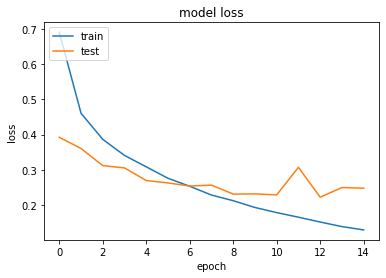

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

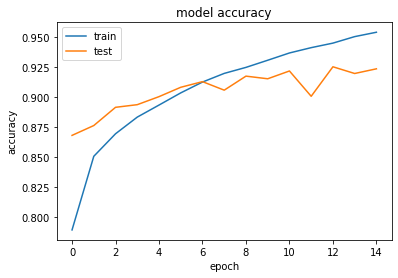

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Examining the Predictions of the Model

In [ ]:
predictions2 = model2.predict(test_ds)

In [ ]:
predictions2[0]

array([2.05468150e-05, 2.35221323e-05, 5.66145900e-06, 1.00886391e-05,
       7.64771994e-06, 2.99582862e-05, 1.19781325e-05, 7.91537150e-06,
       1.13091101e-05, 9.99871373e-01], dtype=float32)

In [ ]:
test_labels[0]

9

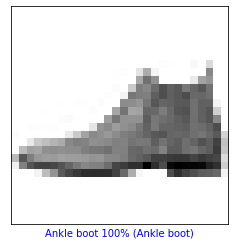

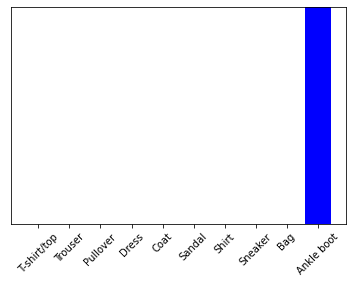

In [ ]:
# Show the 0th image:
index = 0
utils.plot_image_and_prob(predictions2, test_labels, test_images, i=index, big=True, class_names=class_names)

Confusion matrix


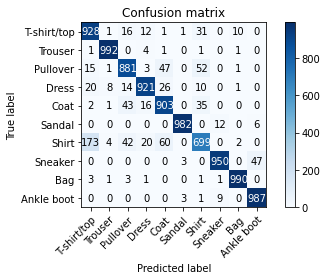

In [ ]:
# As always - let's convert the probabilities array into classes
predicted_classes2 = utils.label_with_highest_prob(predictions2)

# Plot the matrix
utils.plot_confusion_matrix(y_pred=predicted_classes2, y_true=test_labels, classes=np.array(class_names))

In [ ]:
from sklearn.metrics import classification_report,roc_curve,confusion_matrix
print('Classification Report\n',classification_report(test_labels, predicted_classes2))

Classification Report
               precision    recall  f1-score   support

           0       0.81      0.93      0.87      1000
           1       0.98      0.99      0.99      1000
           2       0.88      0.88      0.88      1000
           3       0.94      0.92      0.93      1000
           4       0.87      0.90      0.89      1000
           5       0.99      0.98      0.99      1000
           6       0.84      0.70      0.76      1000
           7       0.98      0.95      0.96      1000
           8       0.99      0.99      0.99      1000
           9       0.95      0.99      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



### Combining Both Cutmix and Cutout Augmented Images

In [ ]:
# Concatenate both the training datasets - i.e. cutmix and cutout
train_ds_mixed = train_ds_cmu.concatenate(train_ds_cutout)

# Create the new dataset after shuffling
train_ds_combined = (
    train_ds_mixed.shuffle(1024)
)

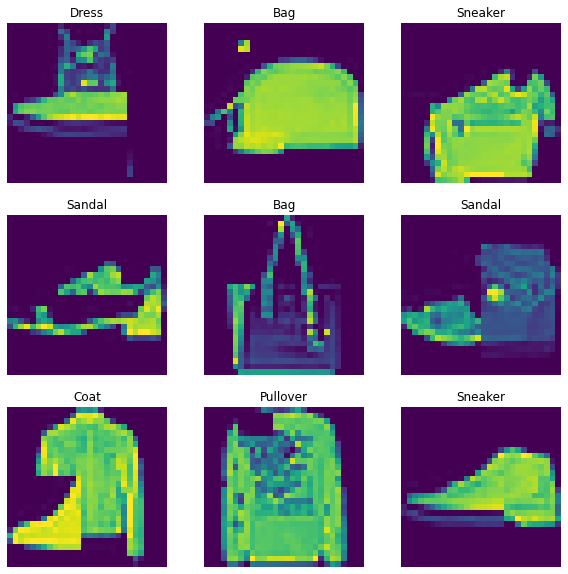

In [ ]:
# Preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_ds_mixed))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i].numpy().transpose(2,0,1)[0])
    plt.axis("off")

In [ ]:
train_ds_combined.cardinality().numpy()

3750

3750 images were created. 

#### Instantiating AlexNet Model and Saving Model

In [ ]:
model3 = alexnet_model()

In [ ]:
model3.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_ds_combined, validation_data=test_ds, epochs=15)

test_loss3, test_accuracy3 = model3.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy2 * 100))

Epoch 1/15
3750/3750 [==============================] - 228s 58ms/step - loss: 0.8457 - accuracy: 0.7669 - val_loss: 0.4151 - val_accuracy: 0.8566
Epoch 2/15
3750/3750 [==============================] - 223s 58ms/step - loss: 0.6634 - accuracy: 0.8224 - val_loss: 0.3060 - val_accuracy: 0.8929
Epoch 3/15
3750/3750 [==============================] - 234s 59ms/step - loss: 0.5875 - accuracy: 0.8429 - val_loss: 0.2684 - val_accuracy: 0.9071
Epoch 4/15
3750/3750 [==============================] - 222s 58ms/step - loss: 0.5410 - accuracy: 0.8585 - val_loss: 0.2576 - val_accuracy: 0.9085
Epoch 5/15
3750/3750 [==============================] - 230s 58ms/step - loss: 0.5063 - accuracy: 0.8669 - val_loss: 0.2532 - val_accuracy: 0.9093
Epoch 6/15
3750/3750 [==============================] - 221s 57ms/step - loss: 0.4773 - accuracy: 0.8769 - val_loss: 0.2138 - val_accuracy: 0.9252
Epoch 7/15
3750/3750 [==============================] - 223s 57ms/step - loss: 0.4503 - accuracy: 0.8846 - val_loss: 0

In [ ]:
model3.save_weights("/content/drive/MyDrive/AkshatBhat-CodingTask/alexnet_model_weights_combined.h5")

In [ ]:
model3.save("/content/drive/MyDrive/AkshatBhat-CodingTask/alexnet_model_combined.h5")

#### Plotting the Training and Testing Loss and Accuracy Curves

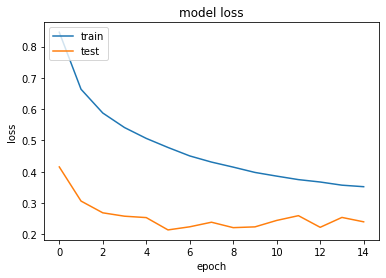

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

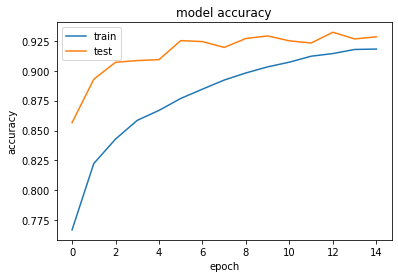

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Examining the Predictions of the Model

In [ ]:
predictions3 = model3.predict(test_ds)

In [ ]:
predictions3[0]

array([4.6220764e-05, 5.6933899e-05, 6.3935108e-06, 5.4565138e-05,
       1.0905761e-04, 9.8027021e-04, 2.5577434e-05, 4.4633434e-04,
       3.4672103e-04, 9.9792790e-01], dtype=float32)

In [ ]:
test_labels[0]

9

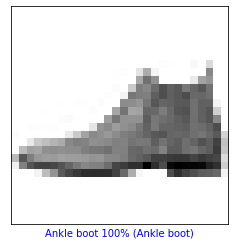

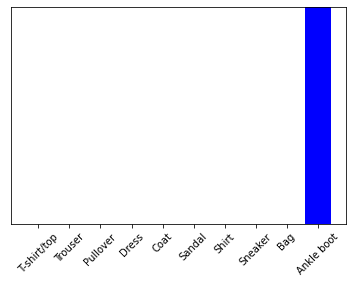

In [ ]:
# Show the 0th image:
index = 0
utils.plot_image_and_prob(predictions3, test_labels, test_images, i=index, big=True, class_names=class_names)

Confusion matrix


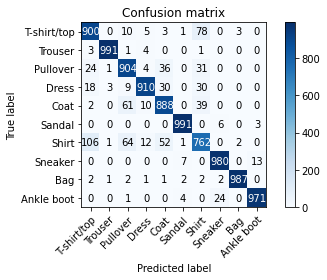

In [ ]:
# As always - let's convert the probabilities array into classes
predicted_classes3 = utils.label_with_highest_prob(predictions3)

# Plot the matrix
utils.plot_confusion_matrix(y_pred=predicted_classes3, y_true=test_labels, classes=np.array(class_names))

In [ ]:
from sklearn.metrics import classification_report,roc_curve,confusion_matrix
print('Classification Report\n',classification_report(test_labels, predicted_classes3))

Classification Report
               precision    recall  f1-score   support

           0       0.85      0.90      0.88      1000
           1       0.99      0.99      0.99      1000
           2       0.86      0.90      0.88      1000
           3       0.96      0.91      0.94      1000
           4       0.88      0.89      0.88      1000
           5       0.99      0.99      0.99      1000
           6       0.81      0.76      0.78      1000
           7       0.97      0.98      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.98      0.97      0.98      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



### Conclusion



1.   In this coding task, Fashion MNIST Dataset was used in which two image augmentation techniques namely, cutmix and cutout operations were performed before using the AlexNet Model.
2.   When the dataset was augmented using cutmix operation, an average accuracy of 90.84% and F-1 score of 91% was obtained as observed from the classification report and the confusion matrix. It is observed that the testing loss was always less than the training loss.
3.   When the dataset was augmented using cutout operation, an average accuracy of 92.33% and F-1 score of 92% was obtained as observed from the classification report and the confusion matrix. It is observed that after the sixth epoch, the training loss becomes lesser than the testing loss, indicating that the model might be overfitting.
4. When the dataset was augmented using both cutmix and cutout operations, an average accuracy of 92.33% and F-1 score of 93% was obtained as observed from the classification report and the confusion matrix. It is observed that gradually till the fifteenth epoch, the testing and training loss decrease to converge.
5. It is observed that for the Shirt class, all the models did not perform as well as they did for the other classes.